In [28]:
# Import required libraries
import pandas as pd
import numpy as np
from math import log2
from random import shuffle


In [29]:
DATA_PATH = "data/breast-cancer.data"  # Dataset path 
MIN_SAMPLES_SPLIT = 5  # Minimum samples required to split a node (K)
NUM_FOLDS = 10   # Number of folds for cross-validation



# Column names of the dataset
column_names = [
    "class", "age", "menopause", "tumor-size", "inv-nodes",
    "node-caps", "deg-malig", "breast", "breast-quad", "irradiat"
]

# Load the dataset
df = pd.read_csv(DATA_PATH, header=None, names=column_names)

# This line displays the first few rows
df.head()


,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [30]:
# Check shape and basic info
print("Initial shape:", df.shape)
print("\nMissing values per column:\n", df.isin(['?']).sum())

# Check class balance
print("\nClass distribution:\n", df['class'].value_counts())


Initial shape: (286, 10)

Missing values per column:
 class          0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      8
deg-malig      0
breast         0
breast-quad    1
irradiat       0
dtype: int64

Class distribution:
 class
no-recurrence-events    201
recurrence-events        85
Name: count, dtype: int64


In [31]:
# Replace '?' with NaN
df.replace("?", np.nan, inplace=True)

# Drop rows with missing values
df.dropna(inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

print("After cleaning:", df.shape)
df.head()


After cleaning: (277, 10)


,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [32]:
# Show value counts for each categorical feature
for col in df.columns:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())



class value counts:
class
no-recurrence-events    196
recurrence-events        81
Name: count, dtype: int64

age value counts:
age
50-59    91
40-49    89
60-69    55
30-39    36
70-79     5
20-29     1
Name: count, dtype: int64

menopause value counts:
menopause
premeno    149
ge40       123
lt40         5
Name: count, dtype: int64

tumor-size value counts:
tumor-size
30-34    57
25-29    51
20-24    48
15-19    29
10-14    28
40-44    22
35-39    19
50-54     8
0-4       8
5-9       4
45-49     3
Name: count, dtype: int64

inv-nodes value counts:
inv-nodes
0-2      209
3-5       34
6-8       17
9-11       7
15-17      6
12-14      3
24-26      1
Name: count, dtype: int64

node-caps value counts:
node-caps
no     221
yes     56
Name: count, dtype: int64

deg-malig value counts:
deg-malig
2    129
3     82
1     66
Name: count, dtype: int64

breast value counts:
breast
left     145
right    132
Name: count, dtype: int64

breast-quad value counts:
breast-quad
left_low     106
left_up  

In [33]:
def entropy(data):
    labels = data['class'].value_counts(normalize=True)
    return -sum(p * log2(p) for p in labels)

def information_gain(data, feature):
    total_entropy = entropy(data)
    values = data[feature].unique()
    weighted_entropy = 0
    for v in values:
        subset = data[data[feature] == v]
        weighted_entropy += (len(subset) / len(data)) * entropy(subset)
    return total_entropy - weighted_entropy


In [35]:

def build_tree(data, features):
    if len(data['class'].unique()) == 1:
        return data['class'].iloc[0]
    if len(features) == 0 or len(data) < MIN_SAMPLES_SPLIT:
        return data['class'].mode()[0]

    gains = {f: information_gain(data, f) for f in features}
    best_feature = max(gains, key=gains.get)
    tree = {best_feature: {}}

    for value in data[best_feature].unique():
        subset = data[data[best_feature] == value]
        if subset.empty:
            tree[best_feature][value] = data['class'].mode()[0]
        else:
            new_features = [f for f in features if f != best_feature]
            tree[best_feature][value] = build_tree(subset, new_features)
    return tree


In [36]:
def predict(tree, sample):
    if not isinstance(tree, dict):
        return tree
    feature = next(iter(tree))
    value = sample[feature]
    if value in tree[feature]:
        return predict(tree[feature][value], sample)
    else:
        return "unknown"


In [38]:
def k_fold_cross_validation(df, k=NUM_FOLDS):
    data = df.sample(frac=1).reset_index(drop=True)  
    folds = np.array_split(data, k)  
    accuracies = []

    for i in range(k):
        test = folds[i]
        train = pd.concat([folds[j] for j in range(k) if j != i])

        features = [f for f in train.columns if f != 'class']
        tree = build_tree(train, features)

        correct = 0
        for _, row in test.iterrows():
            pred = predict(tree, row)
            if pred == row['class']:
                correct += 1
        accuracy = correct / len(test)
        accuracies.append(accuracy)
        print(f"Fold {i+1} Accuracy: {accuracy:.3f}")

    avg_acc = np.mean(accuracies).round(3)
    print(f"\nAverage Accuracy: {avg_acc}")
    return accuracies


In [39]:
accuracies = k_fold_cross_validation(df)


/home/studen/ID3_BreastCancer/venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Fold 1 Accuracy: 0.464
Fold 2 Accuracy: 0.571
Fold 3 Accuracy: 0.643
Fold 4 Accuracy: 0.714
Fold 5 Accuracy: 0.750
Fold 6 Accuracy: 0.571
Fold 7 Accuracy: 0.607
Fold 8 Accuracy: 0.741
Fold 9 Accuracy: 0.741
Fold 10 Accuracy: 0.741

Average Accuracy: 0.654


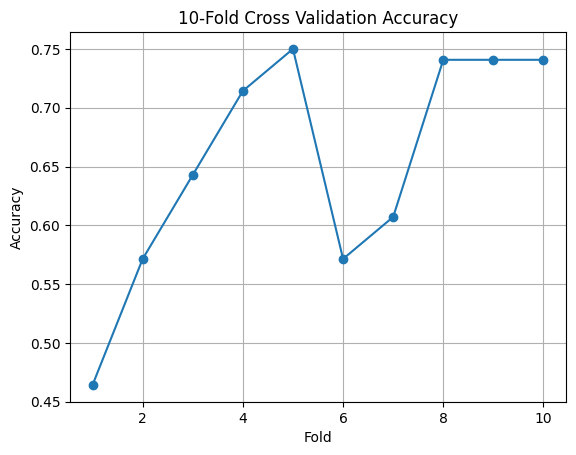

In [40]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(accuracies)+1), accuracies, marker='o')
plt.title("10-Fold Cross Validation Accuracy")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

